## Classifying Cakes

Let's start from scratch, with lesson 1 of fastai, and build our own picture classifier. 

First, we import everything we'll need from fastai's vision library. FastAI's normal approach is to do a `from fastai.vision.all import *`, but in this case I want to be explicit about what I'm using and why.

In [22]:
from fastai.vision.all import ImageDataLoaders, resnet34, error_rate, PILImage, Path, Resize, cnn_learner, aug_transforms
from fastai.vision.widgets import ImageClassifierCleaner
from fastbook import widgets

A while ago, I downloaded a bunch of images from a Bing image search of various kinds of baked foods: cakes, cookies, pies, etc. So, we first set up the path to those files. I have them stored on an external share, but it turns out that disc i/o to those files matters quite a lot in feeding data to the video card, so I copied them to a local drive. This was also a chance to clean up the image files a little bit. In a previous training run, the Python Image Library (PIL) complained about some of the files having invalid EXIF information, so in the copy process I stripped out all of the exif data from the images. (you can do this by just opening the file in PIL, then saving it somewhere else, so the copy process was just opening the file in PIL, then saving it from PIL.) 

As an aside: that process wasn't quite enough to get rid of all the warnings on images. I had to also check the transparency data on several of the images (attempting to `image.convert()` them in PIL) to get rid of all of the warnings during training. This mostly involved running `image.convert("L")` on each image, and removing the ones that triggered an error...these were all .png files, for some reason. 

To be fully transparent, moderating the data set was actually a big time sink in this project. A non-trivial number of the images downloaded from Bing turned out to not be images at all (my fault for making a downloader that didn't check, and just got the URLs from an image search blindly), or were corrupted either on the original system or during download. Each one of those caused the learning process to crash, so I had to go through the data sets manually to make sure all of them were really images before starting this process. 

In [2]:
path = Path("/home/g-clef/local_ml_data_copy/Image_data/Baked_goods")

The files in that path are organized into folders, named for the kind of thing, so there are sub-folders under `Baked_goods` named things like `bagel` or `cake` or `cookie`. FastAI can take that folder name, and use it as the class name for classification, which we'll use in a sec.

The next thing to do, once you have the path, is to build a "DataLoader", which is a helper class in FastAI that handles turning your input files into batches ready for use in a deep learning model. The DataLoader does a bunch of things at once, so we'll instantiate it, then talk about its arguments.

In [3]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))

First, we're using an `ImageDataLoader` since we're working with images in this case. `ImageDataLoader` handles formatting input batches from the source image files, applying transforms to batches, etc. You don't normally instantiate those directly, but instead use one of their factory methods. In this case I'm using `from_folder`, which builds a data loader that takes the class values from the names of the containing folders.

The first argument we give to the factory is the path to the images. 

In some cases, you want to separate the `valid`, and `training` data into separate data collections (in case you want to make sure that your test set and training set are free from biases). If you were doing that, you'd next supply `valid=something` and `train=somethingelse` arguments that tell it the subfolder names where the valid and training data sets are (they need to be consistent across all the class-name subfolders). In this case, I'm asking FastAI to automatically create a `valid` set out of the full set of images, by asking it to set aside 20% of the images to test it's results. That's the `valid_pct=0.2` argument.

next, you pass it a "seed". This is a value used to initialize the random number generator for use in picking things like the members of the training set vs validation set above. We set this to a static number so that each run of this system uses the same random numbers (yes, that's a bit of a weird sentence to write), so that our results are somewhat re-producable.

Lastly, we pass it a set of transforms. These are functions to run against the images before using them in the classifier. In this case we're just forcing all the images to the same size. Other options include ways to make synthetic training data by cropping the image, rotating it, zooming in, etc. There are two kinds of transforms `item_tfms`, which are applied each image one-by-one, and `batch_tfms`, which are applied to whole batches of images.

Once that's all done, we can hand that data loader to the actual deep learning model.

In [4]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In this case, we're using a `cnn_learner`, which is a "Convolutional Neural Network" learning model. I'm not super-well versed on defining one of those  yet, but they're apparently the de-facto standard in image-based ML at the moment, so FastAI recommends using them.

We pass it first the data loader we made above, to use as its learning data.

Next we pass it an architecture, in this case called `resnet34`. Resnet is a pre-created architecture, which has already been trained to identify lots of categories of things (so the variables in it will be re-used later, rather than entirely determined during training.), so it's sometimes called a "model", which is really just shorthand for an architecture that's been trained.

Lastly we specify a "metric". The "metric" is *not* the function that's used in training, it's just a function for human consumption that's printed out during training to say how well the system is working after each round of training. In this case "error rate" is the percent of images in the "validation" set that are classified incorrectly by the system after training.

With all that built, we now do something from FastAI learning called "fine tuning". Fine tune is a special helper function in FastAI that codifies a few common steps in transfer learning. It's important to mention at this point that by using `resnet` as a starting model we're doing something called "transfer learning". Basically that means we're using a model trained for one thing, and applying that model with most of its existing training parameters, keeping most of that, and just re-training it on our new data. The advantage of this approach is that we're not starting from scratch to train a new model every time we build a new model. Since `resnet` has been trained to identify many things in real life (cats, cars, people, etc), we are going to "transfer" that training to identify baked goods in this case.

What fine_tune does is two learning passes (we'll talk more about what a learning pass is later), one with the model "frozen", and one with it "unfrozen". A "frozen" model is only training the last layer, while an unfrozen model is training the whole thing. The "1" argument to `fine_tune` is the number of "epochs" to train over. An "epoch" is the number of passes across the dataset to take, so 1 epoch is basically sending each image to the model once only. (in this case twice, once when frozen, once when unfrozen). 

This is difficult to  understand without talking about the model itself. ML models are generally multi-layer things, where a mathematical function is applied to the input, then a layer of an "activation" function is applied (which is basically a decision about whether to include these results to the layer above it, with a "weight" to indicate the strength of that inclusion), then another layer of mathematical function is applied to that output and another "activation" function, and on and on, for many layers. The last layer with its activations is the one that has to match the expected number of classes you're working with, so it's the layer that's removed and re-trained in transfer learning.

In [5]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,3.090754,2.069730,0.615207,01:22


epoch,train_loss,valid_loss,error_rate,time
0,2.029015,1.551679,0.496928,01:27


50% error rate, aka 50% success. That's...not great. It's better than random chance, though: with 15 categories, random chance would put it's success around 6%. So it's *much* better than rollling dice, but we'd like to do better than 50% success in general.

Before going to improvements, we can also look at what it would look like to use this model in a prediction system. First, we'll use a widget in jupyter to make an upload dialog:

In [6]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Click the Upload widget, select a file, then run the cells below, which will take the image uploaded there, and hand it to the model to make a prediction.

In [7]:
img = PILImage.create(uploader.data[0])
learn.predict(img)

('bagel',
 tensor(0),
 tensor([9.6195e-01, 1.4546e-04, 5.0796e-05, 3.0003e-03, 7.1292e-04, 2.2523e-05, 2.2814e-05, 2.1200e-03, 1.4041e-04, 3.1645e-02, 4.6440e-05, 2.4005e-05, 2.7125e-05, 4.2550e-05, 5.2821e-05]))

In this case, I uploaded the wikipedia illustration for the "bagel" entry, so the prediction is correct. The other two responses from `learn.predict` are a decode of the prediction (if decoding is necessary, and configured on the learner...need to learn more about this) and the full tensor of the predictions for all the possible classes in the model. The "prediction" is really just the biggest of these predictions, but if the biggest prediction is close to another prediction ("close" being left as an exercise for the reader), then this is indicating that this may not be a strong prediction, that there's a potential for "confusion" (confusion matrices will come later).

To map the predictions back to the original classes, you can look at the `vocab` of the data loader:

In [8]:
dls.vocab

['bagel', 'biscuit', 'bread', 'bread_bun', 'bread_roll', 'brownie', 'cake', 'cookie', 'cracker', 'doughnut', 'flatbread', 'muffin', 'pastry', 'pie', 'tart']

Interestingly, this shows that the model was fairly confident this was a bagel (96%), and the next most confident answer (3%) was doughnut, which makes sense.

Let's try a few things to improve it. First, let's try the brute-force approach of just training more. So, we'll start over with the model, and fine_tune for, let's say, 5 epochs instead of 1.

In [9]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,3.099779,2.021530,0.617512,01:24


epoch,train_loss,valid_loss,error_rate,time
0,2.099488,1.609940,0.495392,01:29
1,1.703257,1.327449,0.417051,01:28
2,1.289828,1.154090,0.371736,01:29
3,1.004864,1.057497,0.338710,01:26
4,0.826204,1.053456,0.341782,01:27


That seems to have made things much better. 34% error is better than 50%. 

There are two things to be concerned with, though: first, more training obviously take more time, but more importantly the more you train, the more risk you run that the system is just memorizing the training images and "overfitting". You can start to see that happening at the last training epoch above: the error_rate goes *up* as it trains more. From this naive analysis it looks like 4 rounds of training are as good as it's going to get by just training more. 

Can we better yet?

Let's go back to just one round of training, but look at modifying the "learning rate". The "learning rate" is, at a high level, the size of the "step" that the model.

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

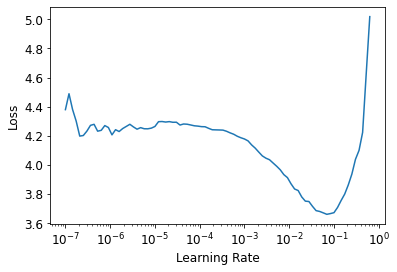

In [10]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

This is a plot of the "loss" (a reasonable aproximation for accuracy) after some training for given learning rates. What we're looking for is a position where loss is decreasing, preferrably as steeply as possible. Their process makes a recommendation, which we'll use: 7e-3. Let's try that.

In [13]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.799910,2.039785,0.599846,01:23


epoch,train_loss,valid_loss,error_rate,time
0,1.671329,1.305015,0.423963,01:29


interesting that this made things a few precent better just by picking a better learning rate. Let's try combining the multiple rounds and the better learning rate:

In [14]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, base_lr=7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.806010,2.055050,0.599846,01:26


epoch,train_loss,valid_loss,error_rate,time
0,1.705358,1.460804,0.440092,01:27
1,1.321765,1.179331,0.377880,01:27
2,0.900357,0.915768,0.316436,01:28
3,0.582072,0.817075,0.279570,01:28


28% error aka 72% accurate. That's getting pretty good. Can we do even better? 

Let's talk about adding some more transforms to the imagedataloader. that should make a bunch of "synthetic" data, making our effective training set bigger. The idea for this is that you do things like warping the image, flipping them, zooming in on sections of an image, rotating them etc. each warped, flipped, zoomed, etc, image is effectively another unique picture, so can be used as a part of the training set.

FastAI includes a built-in method called "aug_transforms", which does basically *all* of the above. You can, in theory, tune each of these settings, but at the moment let's just try it with the defaults, and with the previous settings. 

In [16]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224), batch_tfms=aug_transforms())
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.888712,2.161457,0.632104,01:23


epoch,train_loss,valid_loss,error_rate,time
0,1.817291,1.357167,0.441628,01:28


Interestingly, that made the first round a slight bit worse. Let's see if it gets better after 4 rounds.

In [17]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224), batch_tfms=aug_transforms())
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, base_lr=7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.865842,2.173698,0.624424,01:24


epoch,train_loss,valid_loss,error_rate,time
0,1.847943,1.645819,0.474654,01:27
1,1.453540,1.159938,0.388633,01:28
2,1.116782,0.989105,0.334869,01:27
3,0.879857,0.915864,0.307988,01:28


welp. That made things worse. Let's double-check if the learning rate is still right.

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.007585775572806597)

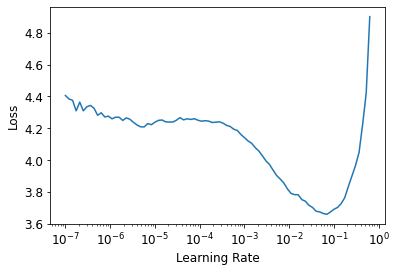

In [18]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224), batch_tfms=aug_transforms())
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

Nope. Learning rate recommendation is the same. Let's see if more rounds are feasible now that we have more data.

In [19]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224), batch_tfms=aug_transforms())
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(7, base_lr=7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.874673,2.228121,0.624424,01:24


epoch,train_loss,valid_loss,error_rate,time
0,1.830977,1.598100,0.486943,01:25
1,1.500945,1.420767,0.440092,01:26
2,1.275287,1.275369,0.407066,01:26
3,1.070976,1.000561,0.323349,01:28
4,0.852416,0.865703,0.282642,01:28
5,0.673967,0.808629,0.274962,01:26
6,0.556745,0.780398,0.257296,01:28


Interestingly, it does get better. Train loss and valid loss are also better, and consistently dropping still. Now, let's look at the data itself. One of the next things to look at are the images that are mis-classified most often, or are the most confusing for the system. Helpfully, FastAI includes a widget to help you see these, called the ImageClassifierCleaner. It will show you the highest-loss images, and let you choose to manually classify them or remove them.

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner